# Imports

In [3]:
import numpy as np
from itertools import product

from utility import get_session_trials
from predicting import predict_position
from predicting import predict_tgtDir
from data_processing import create_df
from data_processing import get_data
from predicting import predict_pos_on_firing_rates
from plotting import compare_all_projections
from plotting import compare_projections
from plotting import compare_two_projections_over_session
import pandas as pd
from tqdm.notebook import tqdm

from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from final_functions import create_dataset
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from pca_functions import session_PCA

from sklearn.model_selection import cross_val_score, KFold

# Mean centering the position per session

Creating the datasets.

In [2]:
tD = create_dataset(bin_size=0.01, mean_center=True, print_info=False)
tD2 = create_dataset(bin_size=0.01, mean_center=False, print_info=False)


Predicting position using firing rates.

In [3]:
trials = get_session_trials(tD[1])
trials2 = get_session_trials(tD2[1])

score = predict_pos_on_firing_rates(trials, Ridge(), 0, 200, folds=20, scorer='r2')
score2 = predict_pos_on_firing_rates(trials2, Ridge(), 0, 200, folds=20, scorer='r2')

print(f'Mean R2 with mean_centered position: {score}')
print(f'Mean R2 without mean_centered position: {score2}')

Mean R2 with mean_centered position: 0.20437089262760644
Mean R2 without mean_centered position: 0.2115091185496641


Result: No consistent effect. I've decided to keep using mean_centered data though, for clarity.

# Focus: Bin Size update.

In [4]:
tD = create_dataset(bin_size=0.01, print_info=False)
tD2 = create_dataset(bin_size=0.05, print_info=False)

Checking consistency of data for multiple bin sizes.

Note: trialID 182 while we're taking 352th trial seems weird but is due to way of trial storage in tD. Verified correct.

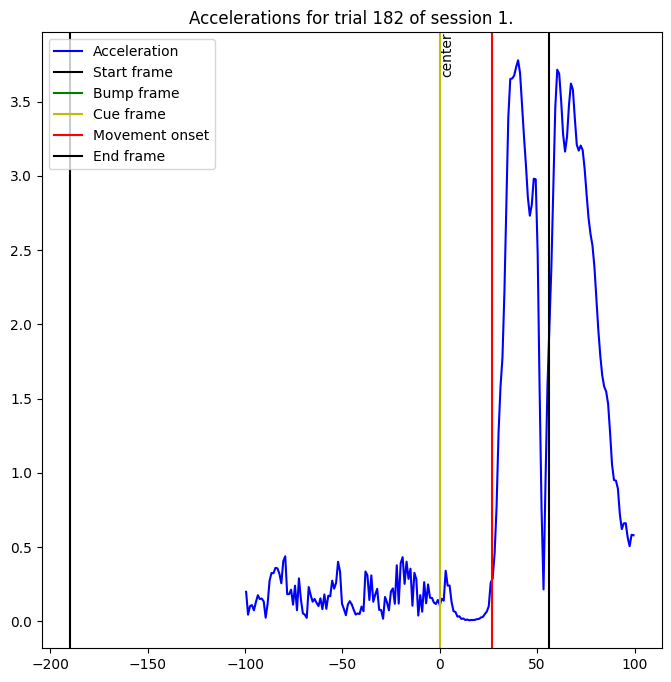

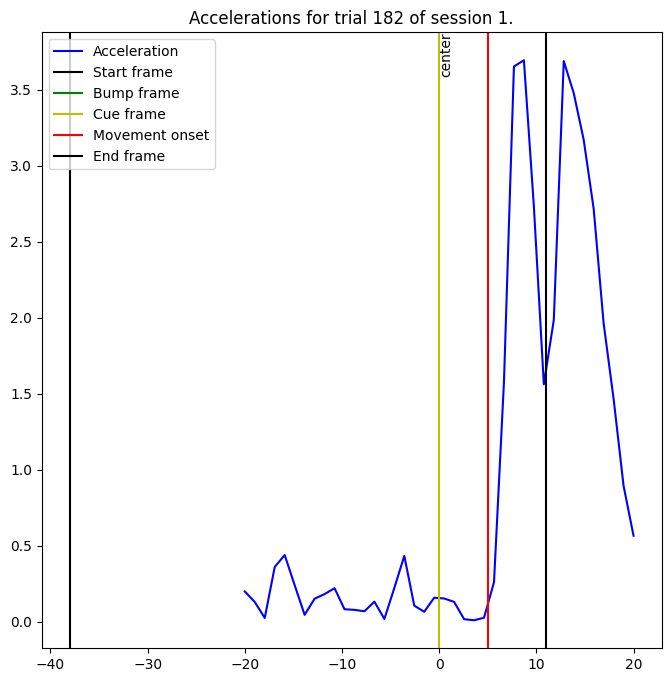

In [5]:
trials = get_session_trials(tD[1])
trials2 = get_session_trials(tD2[1])

a = trials[352]
b = trials2[352]

a.plot_acceleration()
b.plot_acceleration()

Plotting firing rates:

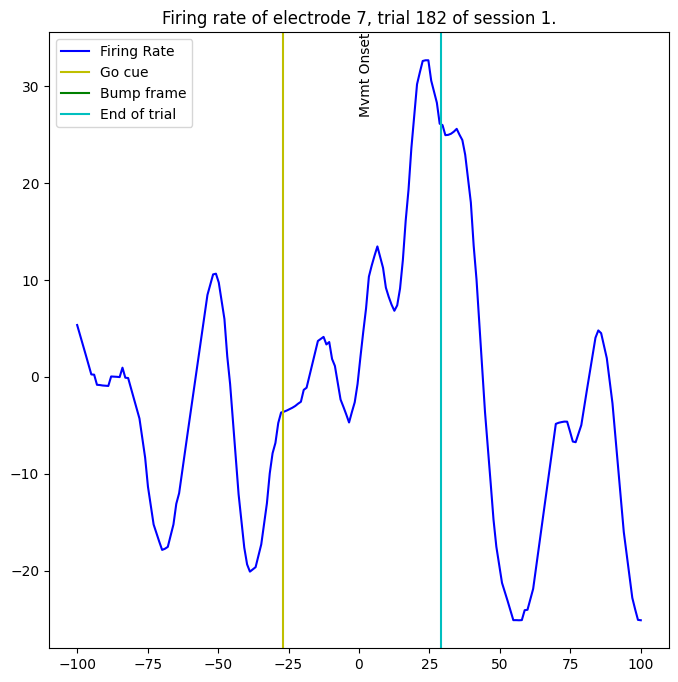

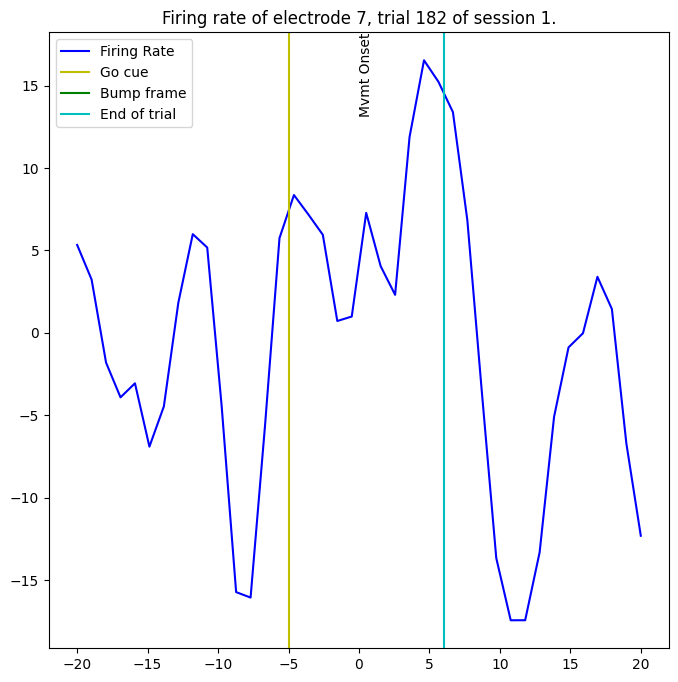

In [7]:
a.plot_firing_rates()
b.plot_firing_rates()

Plotting position

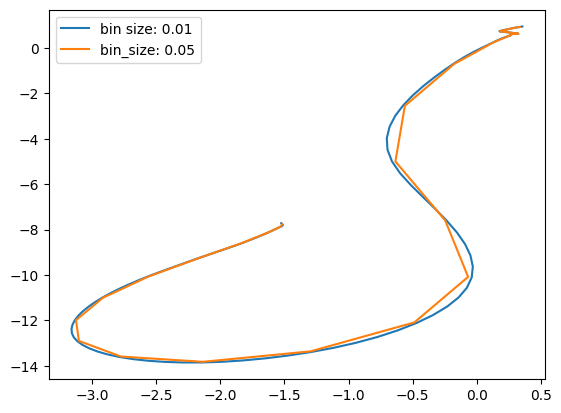

In [8]:
plt.plot(a.pos[:, 0], a.pos[:, 1], label='bin size: 0.01')
plt.plot(b.pos[:, 0], b.pos[:, 1], label='bin_size: 0.05')
plt.legend()
plt.show()

Predicting position based on firing rate

In [9]:
score = predict_pos_on_firing_rates(trials, Ridge(), 0, 300, 10, 'r2')
score2= predict_pos_on_firing_rates(trials2, Ridge(), 0, 300, 10, 'r2')

print(f'R2 with bin size of 10ms: {score}')
print(f'R2 with bin size of 50ms: {score2}')

R2 with bin size of 10ms: -0.2732248228741968
R2 with bin size of 50ms: 0.5764266250692657


# Predicting position based on firing rate

In [10]:
tD = create_dataset(bin_size=0.05, print_info=False)

### Investigating bump direction and window size.

The following graph will show the $r^2$ score on the y-axis, where the x-axis is the window of time taken into account post-movement onset.
Each line is a direction of passive movement, where blue are all active trials and the brown line is all trials combined.

  0%|          | 0/6 [00:00<?, ?it/s]

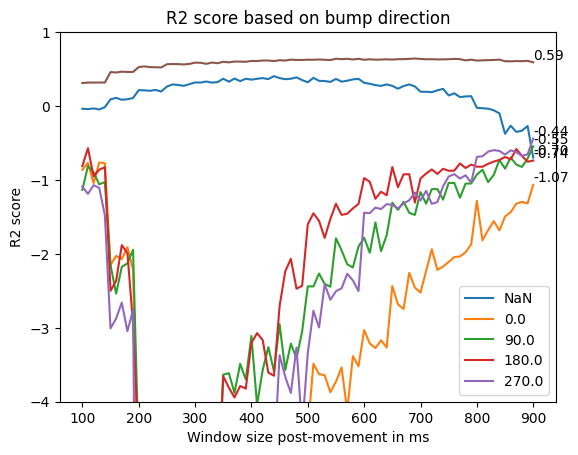

In [11]:
posts = np.linspace(100, 900, 81)
bumpdirs = ['NaN', '0.0', '90.0','180.0','270.0', None]
test_trials = get_session_trials(tD2[1],bumpDir='0.0')
all_scores = []
final_scores = []

#Iterating through bump directions
for i in tqdm(bumpdirs):
    scores = []
    #Iterating through window sizes
    for j in posts:
        test_trials = get_session_trials(tD[1], bumpDir=i)
        scores.append(predict_pos_on_firing_rates(test_trials, Ridge(), 0, j, 10, 'r2'))
    all_scores.append(scores)
    final_scores.append(scores[-1])

for i, scores in enumerate(all_scores):
    plt.plot(posts, scores, label=bumpdirs[i])
    plt.text(posts[-1], scores[-1], f'{final_scores[i]:.2f}', fontsize=10, ha='left', va='bottom')
plt.title(f"R2 score based on bump direction")
plt.ylim(-4, 1)
plt.xlabel("Window size post-movement in ms")
plt.ylabel("R2 score")
plt.legend()
plt.show()

All trials combined results in the highest $r^2$ by far.
For passive movement, a longer window is beneficial. For active movement, a shorter window is more beneficial.

### Investigating $r^2$ per session

Code below is for a bin size of 10 ms

  0%|          | 0/4 [00:00<?, ?it/s]

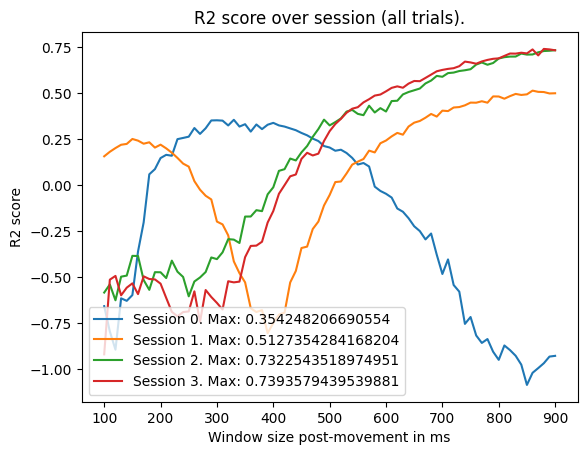

  0%|          | 0/4 [00:00<?, ?it/s]

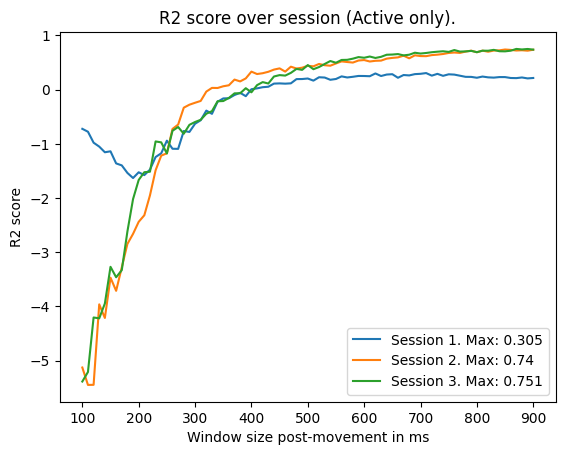

  0%|          | 0/4 [00:00<?, ?it/s]

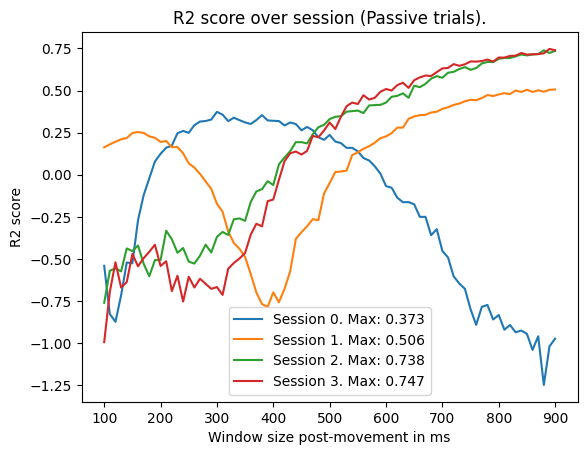

In [12]:
tD = create_dataset(bin_size=0.01, print_info=False)

for i in tqdm([0,1,2,3]):
    trials = get_session_trials(tD[i])
    posts = np.linspace(100, 900, 81)
    scores = []
    max_score = 0
    for j in posts:
        score = predict_pos_on_firing_rates(trials, Ridge(), 0, j, 20, 'r2')
        scores.append(score)
        if score > max_score:
            max_score = score
    plt.plot(posts, scores, label = f'Session {i}. Max: {max_score}')
plt.legend()
plt.title("R2 score over session (all trials).")
plt.xlabel("Window size post-movement in ms")
plt.ylabel("R2 score")
plt.show()

for i in tqdm([0,1,2,3]):
    trials = get_session_trials(tD[i], bumpDir='NaN')
    if len(trials) < 1:
        continue
    posts = np.linspace(100, 900, 81)
    scores = []
    max_score = 0
    for j in posts:
        score = predict_pos_on_firing_rates(trials, Ridge(), 0, j, 20, 'r2')
        scores.append(score)
        if score > max_score:
            max_score = score
    plt.plot(posts, scores, label = f'Session {i}. Max: {np.round(max_score, 3)}')
plt.legend()
plt.title("R2 score over session (Active only).")
plt.xlabel("Window size post-movement in ms")
plt.ylabel("R2 score")
plt.show()

for i in tqdm([0,1,2,3]):
    trials = get_session_trials(tD[i])
    for trial in trials:
        if trial.bumpDir == 'NaN':
            trials.remove(trial)
    if len(trials) < 1:
        continue
    posts = np.linspace(100, 900, 81)
    scores = []
    max_score = 0
    for j in posts:
        score = predict_pos_on_firing_rates(trials, Ridge(), 0, j, 20, 'r2')
        scores.append(score)
        if score > max_score:
            max_score = score
    plt.plot(posts, scores, label = f'Session {i}. Max: {np.round(max_score, 3)}')
plt.legend()
plt.title("R2 score over session (Passive trials).")
plt.xlabel("Window size post-movement in ms")
plt.ylabel("R2 score")
plt.show()

#### Improved trials.
Turns out the frames were taken with the cue frame as the middle, not movement onset. Now, it's fixed.

#### Below, additional session information.

In [13]:
for session in tD.keys():
    active, passive = 0, 0
    for bumpdir in tD[session].keys():
        total = 0
        for mvmtdir in tD[session][bumpdir].keys():
            total += len(tD[session][bumpdir][mvmtdir])
            if bumpdir == 'NaN':
                active += len(tD[session][bumpdir][mvmtdir])
            else:
                passive += len(tD[session][bumpdir][mvmtdir])
        print(f'Session {session}. Bumpdir: {bumpdir}. Total Trials: {total}')
    print(f'Session totals: Active trials: {active} ({np.round(active / (active+passive), 2)}%). Passive trials: {passive} ({np.round(passive / (active+passive), 2)}%)\n')



Session 0. Bumpdir: NaN. Total Trials: 0
Session 0. Bumpdir: 90.0. Total Trials: 153
Session 0. Bumpdir: 0.0. Total Trials: 134
Session 0. Bumpdir: 180.0. Total Trials: 126
Session 0. Bumpdir: 270.0. Total Trials: 123
Session totals: Active trials: 0 (0.0%). Passive trials: 536 (1.0%)

Session 1. Bumpdir: NaN. Total Trials: 661
Session 1. Bumpdir: 270.0. Total Trials: 140
Session 1. Bumpdir: 90.0. Total Trials: 155
Session 1. Bumpdir: 180.0. Total Trials: 156
Session 1. Bumpdir: 0.0. Total Trials: 164
Session totals: Active trials: 661 (0.52%). Passive trials: 615 (0.48%)

Session 2. Bumpdir: NaN. Total Trials: 255
Session 2. Bumpdir: 45.0. Total Trials: 19
Session 2. Bumpdir: 270.0. Total Trials: 25
Session 2. Bumpdir: 135.0. Total Trials: 43
Session 2. Bumpdir: 90.0. Total Trials: 27
Session 2. Bumpdir: 225.0. Total Trials: 20
Session 2. Bumpdir: 0.0. Total Trials: 38
Session 2. Bumpdir: 315.0. Total Trials: 24
Session 2. Bumpdir: 180.0. Total Trials: 30
Session totals: Active trials

### Increasing margin

Had no effect.

#### Question:
Session 2 and 3 are peculiar since there's this sort of stepwise increase in efficiency? Both sessions have more electrodes available than session 0&1. 

In [14]:
tD = create_dataset(bin_size=0.05, print_info=False)
t0, t1, t2, t3 = get_session_trials(tD[0]),get_session_trials(tD[1]), get_session_trials(tD[2]), get_session_trials(tD[3])
for x in [t0, t1, t2, t3]:
    print(f'Amount of working electrodes: {x[1].firing_rates.shape[1]}')

Amount of working electrodes: 39
Amount of working electrodes: 31
Amount of working electrodes: 89
Amount of working electrodes: 85


# Decoding on PCA

### First, create new function which predicts both x, y

### Then, predict using PCA.

In [15]:
PCA_model, PCA_components = session_PCA(tD[1], 10, 0, 20)

In [16]:
trials = get_session_trials(tD[1])

In [17]:

def predict_position(trials, model, prior, post, folds=10, scorer: str = 'r2'):
    if prior != 0:
        prior = int(prior / (1000 * trials[0]._bin_size))
    if post != 0:
        post = int(post / (1000 * trials[0]._bin_size))
    X, y = [], []
    for trial in trials:
        X.append(trial.projections.flatten())
        y.append(np.concatenate(trial.pos[trial.margin-prior: trial.margin+post, ], axis=0))
    cv_scores = cross_val_score(model, X, y , cv=KFold(folds, shuffle=True), scoring=scorer)
    return cv_scores.mean()



  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

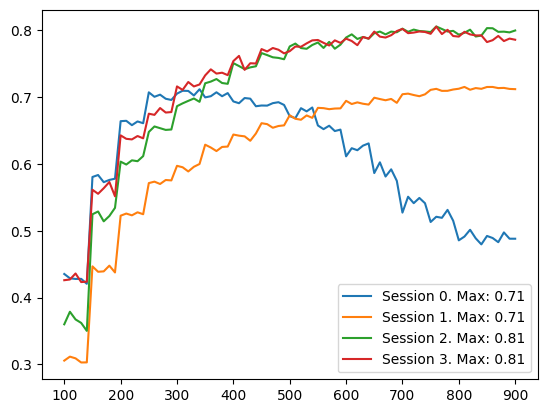

In [18]:
posts = np.linspace(100, 900, 81)

# for post in tqdm(posts):
#     PCA_model, PCA_components = session_PCA(tD[1], 10, 0, post/10)
#     trials = get_session_trials(tD[1])
#     scores.append(predict_position(trials, Ridge(), 0, post, folds=10))
# plt.plot(posts, scores, label=f'R2. Max: {np.round(max(scores), 2)}')
# plt.legend()
# plt.show()


for i in [0, 1, 2, 3]:
    scores = []
    for post in tqdm(posts):
        PCA_model, PCA_components = session_PCA(tD[i], 10, 0, post/10)
        trials = get_session_trials(tD[i])
        scores.append(predict_position(trials, Ridge(), 0, post, folds=10))
    plt.plot(posts, scores, label=f'Session {i}. Max: {np.round(max(scores), 2)}')
plt.legend()
plt.show()


# Creating DataFrame

In [32]:
from data_processing import get_data

base_df = create_df(get_data())
for x in base_df.columns:
    print(x)


trialID
monkey
task
date_time
original_bin_size
result
bumpDir
tgtDir
ctrHoldBump
ctrHold
idx_startTime
idx_endTime
idx_bumpTime
idx_goCueTime
idx_tgtOnTime
shifted
pos
vel
force
markers
joint_ang
joint_vel
muscle_len
muscle_vel
S1_spikes
session


In [35]:
base_df.head()

,trialID,monkey,task,date_time,original_bin_size,result,bumpDir,tgtDir,ctrHoldBump,ctrHold,idx_startTime,idx_endTime,idx_bumpTime,idx_goCueTime,idx_tgtOnTime,shifted,pos,vel,force,markers,joint_ang,joint_vel,muscle_len,muscle_vel,S1_spikes,session
0,1,C,COactpas,2017/9/12 19:55:38.792,0.01,R,90.0,0.0,1,0.806041,303,590,506.0,537.0,537.0,0,"[[nan, nan], [nan, nan], [nan, nan], [nan, nan...","[[nan, nan], [nan, nan], [nan, nan], [nan, nan...","[[nan, nan, nan, nan, nan, nan], [nan, nan, na...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[nan, nan, nan, nan, nan, nan, nan], [nan, na...","[[nan, nan, nan, nan, nan, nan, nan], [nan, na...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0
1,2,C,COactpas,2017/9/12 19:55:38.792,0.01,R,0.0,180.0,1,0.816895,640,906,805.0,852.0,852.0,590,"[[8.935475094481102, -31.802060119224134], [9....","[[63.73225822235801, 11.296112745759396], [62....","[[0.20590744938703034, 0.38687059861809664, -1...","[[0.04978942054357578, 0.23653278319442805, -0...","[[0.9520490613022716, -6.752655735603702, 0.15...","[[-76.52507471137365, -178.4508853274774, 158....","[[0.17495440664472303, 0.044138656358109006, 0...","[[0.018814517660240213, -0.020053455156280292,...","[[1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1,...",0
2,3,C,COactpas,2017/9/12 19:55:38.792,0.01,R,0.0,0.0,1,1.087712,957,1239,1121.0,1183.0,1183.0,906,"[[-9.14633881030376, -31.978787618833515], [-9...","[[-49.860605119934476, 1.1148043203241051], [-...","[[0.237983449807594, -0.33426799017045195, -0....","[[-0.1760884804663, 0.2443760397706238, -0.156...","[[5.113629880643482, 35.682658126304254, 16.19...","[[120.82409283860568, 96.18691977557647, 64.12...","[[0.17623484049299817, 0.04033867033332363, 0....","[[0.0034778078632207066, -0.020280325340218536...","[[0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 1, 0, 0,...",0
3,4,C,COactpas,2017/9/12 19:55:38.792,0.01,R,90.0,180.0,1,0.842982,1289,1535,1449.0,1483.0,1483.0,1239,"[[8.386744447819234, -32.282880582456656], [8....","[[52.05787371739286, 9.934913321701577], [50.7...","[[0.03380549703292097, 0.16650592112202303, -0...","[[0.030395923223784746, 0.23878836898066844, -...","[[0.5247289027153459, -5.272606775352724, -1.6...","[[-10.610336557304901, -46.980106778887034, 39...","[[0.17626483144611824, 0.04464628128722688, 0....","[[0.014451998314510762, -0.008017412031222046,...","[[0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,...",0
4,5,C,COactpas,2017/9/12 19:55:38.792,0.01,R,180.0,0.0,1,0.952397,1585,1832,1740.0,1779.0,1779.0,1535,"[[-9.389637569622131, -32.189430331666586], [-...","[[-51.685636104901576, 23.299104590137944], [-...","[[-0.01385809803887424, 0.25226818070269585, -...","[[-0.177083874101133, 0.24433556689532832, -0....","[[5.228839675926946, 34.545124369734, 16.60823...","[[14.1833885626907, 8.165834918169795, 46.1544...","[[0.1767734984404527, 0.04037466428848858, 0.2...","[[0.00018515179953482094, -0.01378926961201112...","[[0, 0, 1, 0, 0, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0,...",0
